This is a companion notebook for the book [Deep Learning with Python, Third Edition](https://www.manning.com/books/deep-learning-with-python-third-edition). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

The book's contents are available online at [deeplearningwithpython.io](https://deeplearningwithpython.io).

In [1]:
!pip install keras keras-hub --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.9/947.9 kB 52.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.21.1 requires keras-hub==0.21.1, but you have keras-hub 0.22.2 which is incompatible.


In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [ ]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## Timeseries forecasting

### A temperature forecasting example with RNN

In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-09-19 11:55:00--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.40.104, 52.217.196.104, 16.15.219.110, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.40.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  19.6MB/s    in 0.7s    

2025-09-19 11:55:01 (19.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Inspecting the data of the Jena weather dataset

In [109]:
import os
import pandas as pd

fname = os.path.join("jena_climate_2009_2016.csv")

df = pd.read_csv(fname)
display(df.head())

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [110]:
print(df.shape)

(420451, 15)


In [165]:
with open(fname) as f:
    data = f.read()

data

Output hidden; open in https://colab.research.google.com to view.

In [166]:
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
lines[:5]

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60',
 '01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00',
 '01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30']

In [167]:
print(len(lines))

420451


In [168]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


Parsing the data

In [169]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [170]:
temperature

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [171]:
len(temperature)

420451

In [172]:
raw_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

In [173]:
raw_data.shape

(420451, 14)

Plotting the temperature timeseries

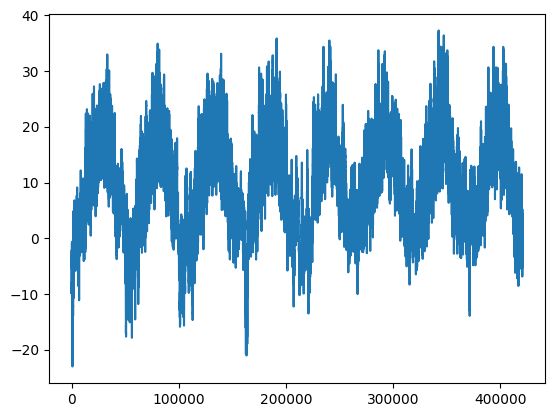

In [174]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

Plotting the first 10 days of the temperature timeseries

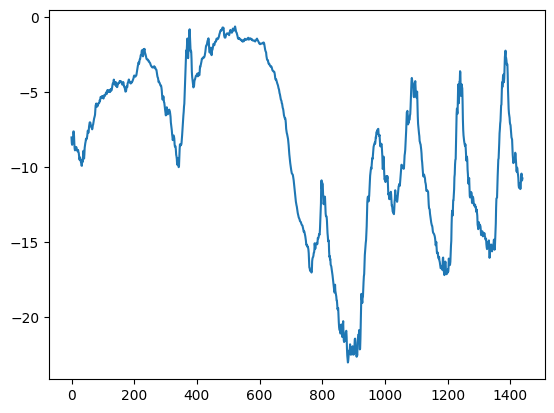

In [175]:
'''
데이터 수집 방식: 온도 데이터는 10분마다 1회씩 기록됩니다.

하루 동안 기록 횟수: 하루는 24시간이고, 한 시간은 60분 → 1시간에 기록되는 횟수 = 60 ÷ 10 = 6번
하루 전체 기록 횟수 = 24시간 × 6번 = 144 데이터 포인트

10일 동안 기록 횟수: 하루에 144개가 있으므로, 10일 동안은 144 × 10 = 1,440 데이터 포인트
'''

plt.plot(range(1440), temperature[:1440])

### The most common timeseries-related task is ***forecasting*** : predicting what will happen next in a series.

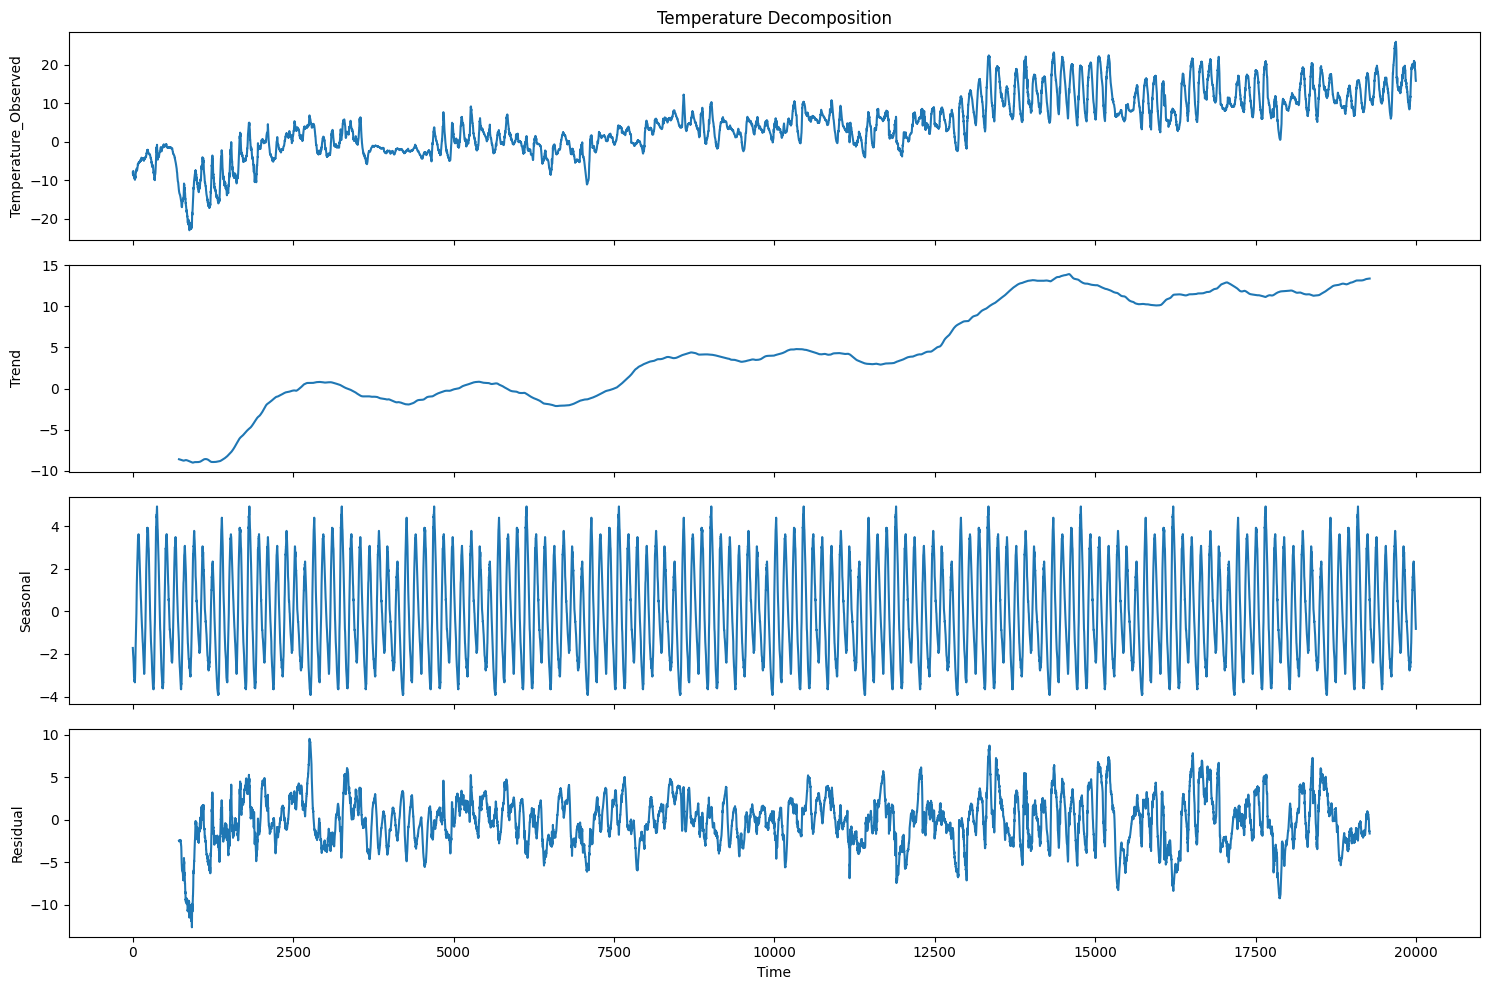

In [176]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'temperature' is a pandas Series or can be converted to one
# If 'temperature' is a numpy array, convert it to a pandas Series with a dummy index or a time index if available
# For simplicity, I'll create a dummy index here. Replace with actual time index if available.
temperature_series = pd.Series(temperature[:20000])

# Perform decomposition (additive model is often suitable for temperature data)
decomposition = seasonal_decompose(temperature_series, model='additive', period=1440) # Assuming a daily pattern of 1440 data points

# Plot the decomposed components as separate plots
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Temperature_Observed')
axes[0].set_title('Temperature Decomposition')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Time')

plt.tight_layout()
plt.show()

### Unlike the types of data you’ve encountered so far, working with timeseries involves understanding the dynamics of a system—its periodic cycles, how it trends over time, its regular regime and its sudden spikes."

### 위 그림의 사이클, 주기를 해석하고 계절은 언제인가?

### 시간을 고려하여 훈련과 검증, 데이터를 split 한다
Computing the number of samples we'll use for each data split

### 데이터 분할
- 전체 데이터는 420,451개이며, 다음과 같이 훈련, 검증, 테스트 데이터로 구분

> - 훈련(Training) 데이터: 210,225개 (약 50%)

> - 검증(Validation) 데이터: 105,112개 (약 25%)

> - 테스트(Test) 데이터: 105,114개 (약 25%)

In [177]:
print("num_total_raw_data", len(raw_data))

# 시간 순서대로 훈련/검증 데이터 구분하기
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)


num_total_raw_data 420451
num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


#### Preparing the data
Normalizing the data

In [178]:
raw_data.shape

(420451, 14)

In [179]:
raw_data[:num_train_samples].mean(axis=0) # 각 열의 평균값

array([ 988.74929466,    8.82590329,  282.9050718 ,    4.31331863,
         75.87275476,   13.14569946,    9.19414209,    3.95148184,
          5.81050741,    9.30208943, 1218.45204015,    2.14977462,
          3.56048029,  176.4405232 ])

In [180]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Instantiating datasets for training, validation, and testing
- 120시간의 과거 데이터를 보고, 24시간 뒤를 예측하겠다"

In [181]:
# 10분 단위로 기록된 데이터에서 sampling_rate=6을 사용
# 6개의 데이터 포인트(10분 x 6 = 60분)를 건너뛰고 1시간 간격으로 데이터를 샘플링한다는 의미
# 모델은 매 10분마다의 세밀한 변화보다는, 1시간 단위의 큰 패턴을 학습
# 데이터가 10분 단위로 기록되었으므로, 60분(1시간) 간격으로 데이터를 샘플링하려면 6을 설정합니다. (1시간 / 10분 = 6)
sampling_rate = 6

# 모델의 입력으로 사용할 과거 데이터의 window 길이
# 예시에서는 120개 데이터 포인트를 사용했는데, 이는 120시간(5일)에 해당
sequence_length = 120

# delay는 시계열 데이터에서 입력 데이터가 끝나는 시점과 모델이 예측해야 하는 정답 데이터가 시작되는 시점 사이의 간격을 의미
# 즉, 과거 데이터를 사용하여 얼마나 먼 미래를 예측할지를 결정하는 중요한 파라미터
# delay는 예측 문제의 **예측 간격(forecast horizon)**을 정의합니다.
# 예시 코드의 의미: delay = sampling_rate * (sequence_length + 24 - 1)
# sequence_length(120)는 모델이 사용하는 과거 데이터의 길이입니다 (120시간). 24는 예측 목표 시점입니다 (24시간 뒤).
# 아래 계산식은 **"120시간의 과거 데이터를 보고, 24시간 뒤를 예측하겠다"**는 의미를 수식으로 나타낸 것입니다.

delay = sampling_rate * (sequence_length + 24 - 1)
print("delay:", delay)


delay: 858


In [186]:
batch_size = 256

In [182]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples,
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples,
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
)

### A rank-3 timeseries data tensor
- Timesteps : sequence_length: 입력 윈도우의 데이터 포인트 개수 (120개)
- Features : 14 features
- Samples : 256 batch

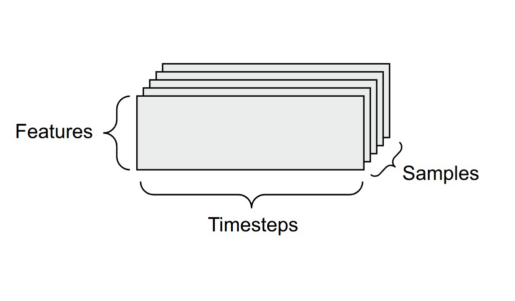

In [194]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/화면 캡처 2025-09-19 221716.jpg')
plt.imshow(img)
plt.axis('off') # Turn off axis numbers and ticks
plt.show()

### 주식 가격 데이터
- 원본: 1분마다 기록된 주식 가격, 최고가, 최저가.
- 표현: 하루치 데이터는 (390, 3) 모양의 2차원 배열(매트릭스)로 표현, 390은 거래일의 분(minute)을, 3은 각 분당 3가지 정보(가격, 최고가, 최저가)를 의미
- 데이터셋: 250일치 데이터는 (250, 390, 3) 모양의 3차원 배열로 저장, 여기서 **250은 샘플(sample)**의 수, 즉 250개의 개별적인 '하루치 데이터'를 의미

### 트윗 데이터
- 원본: 최대 280자로 구성된 트윗.
- 표현: 각 문자는 128개의 항목을 가진 이진 벡터([0, 0, 1, 0, ...] 형태)로 변환, 하나의 트윗은 (280, 128) 모양의 2차원 배열, 280은 글자 수를, 128은 가능한 문자의 개수를 의미
- 데이터셋: 100만 개의 트윗은 (1000000, 280, 128) 모양의 3차원 배열로 저장,  여기서 **1000000은 샘플(sample)**의 수, 즉 100만 개의 개별적인 '트윗'을 의미



## **Tensor**

### 1. Tabular data
<img src='http://jalammar.github.io/images/pandas-intro/0%20excel-to-pandas.png' width=700>

### 2. Image data
<img src='http://jalammar.github.io/images/numpy/numpy-grayscale-image.png' width=700>
<img src='http://jalammar.github.io/images/numpy/numpy-color-image.png' width=700>

### 3. Text data
<img src='http://jalammar.github.io/images/numpy/numpy-nlp-embeddings.png' width=700>
<img src='http://jalammar.github.io/images/numpy/numpy-nlp-bert-shape.png' width=700>

### 택스트 입베딩 데이터를 어떤 형식으로 딥러닝 모델에 입력하는지를 시각적 표현 (그림의 label표기에 오류가 있음)
- **batch_size** : 한 번에 모델에 입력되는 문장(또는 문장 집합)의 개수
- **sequence_length** : 각 문장이 가지는 토큰(token)의 최대 길이로 단어 10개
- **embedding size** : 단어(토큰)별 임베딩 벡터의 차원은 50차원

### 4. Audio and Timeseries data
<img src= 'http://jalammar.github.io/images/numpy/numpy-audio.png' width=700>

In [183]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [184]:
for samples, targets in val_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [185]:
for samples, targets in test_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


#### A common-sense, non-machine-learning baseline

In [195]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


#### Let's try a basic machine learning model
- Dense (완전 연결) 레이어만으로 구성된 간단한 시계열 예측 모델: Fully Connected Neural Network

In [196]:
import keras
from keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Flatten()(inputs) # Flatten layer causes issues with JAX backend
x = layers.GlobalAveragePooling1D()(inputs) # Use GlobalAveragePooling1D instead
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - loss: 53.3842 - mae: 5.6442 - val_loss: 25.5416 - val_mae: 3.9734
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 53ms/step - loss: 23.4037 - mae: 3.8580 - val_loss: 20.6854 - val_mae: 3.6042
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - loss: 22.0161 - mae: 3.7499 - val_loss: 20.2745 - val_mae: 3.5587
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 21.7311 - mae: 3.7229 - val_loss: 20.2232 - val_mae: 3.5537
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 71s 39ms/step - loss: 21.5415 - mae: 3.7068 - val_loss: 20.0909 - val_mae: 3.5415
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 52ms/step - loss: 21.3982 - mae: 3.6950 - val_loss: 20.0535 - val_mae: 3.5372
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 73s 41ms/step - loss: 21.2954 - mae: 3.6867 - val_loss: 20.0114 - val_mae: 3.5348
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - loss: 21.2181 - mae: 3.6802 - val_loss: 20.0253 - val_mae: 3.5345
Epoch 9/10
819/819 ━━━━━

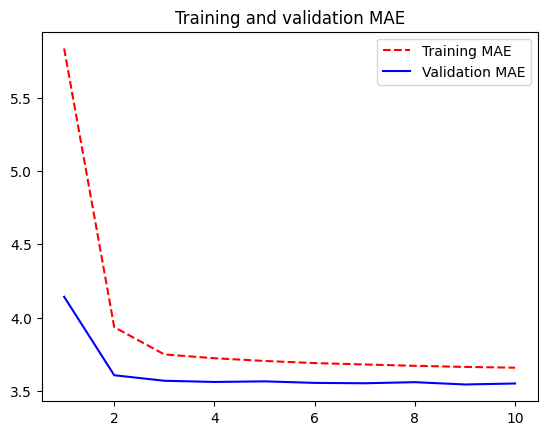

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r--", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

#### Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 74s 89ms/step - loss: 39.0179 - mae: 4.6947 - val_loss: 16.0927 - val_mae: 3.1648
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 99s 119ms/step - loss: 14.7210 - mae: 3.0421 - val_loss: 14.9079 - val_mae: 3.0466
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 67s 82ms/step - loss: 12.7916 - mae: 2.8295 - val_loss: 14.2530 - val_mae: 2.9683
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 67s 81ms/step - loss: 11.7184 - mae: 2.7073 - val_loss: 13.9236 - val_mae: 2.9348
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 67s 81ms/step - loss: 11.1272 - mae: 2.6368 - val_loss: 13.9730 - val_mae: 2.9341
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 66s 81ms/step - loss: 10.6140 - mae: 2.5730 - val_loss: 14.5104 - val_mae: 2.9944
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 67s 82ms/step - loss: 10.2398 - mae: 2.5258 - val_loss: 13.8754 - val_mae: 2.9156
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 67s 81ms/step - loss: 9.9335 - mae: 2.4855 - val_loss: 14.2771 - val_mae: 2.9431
Epoch 9/10
819/819 ━━━━━

### Recurrent neural networks

In [ ]:
import keras
from keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_lstm.keras")
print("Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 108s 129ms/step - loss: 81.4540 - mae: 7.0099 - val_loss: 19.5796 - val_mae: 3.2817
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 103s 122ms/step - loss: 17.7731 - mae: 3.1577 - val_loss: 11.5683 - val_mae: 2.5813
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - loss: 11.9733 - mae: 2.6532 - val_loss: 10.0781 - val_mae: 2.4458
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - loss: 10.5011 - mae: 2.5060 - val_loss: 9.7757 - val_mae: 2.4171
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 103s 125ms/step - loss: 9.7535 - mae: 2.4228 - val_loss: 9.5582 - val_mae: 2.3897
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 99ms/step - loss: 9.1770 - mae: 2.3588 - val_loss: 9.5970 - val_mae: 2.4057
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - loss: 8.5545 - mae: 2.2759 - val_loss: 10.1430 - val_mae: 2.4707
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - loss: 8.2493 - mae: 2.2363 - val_loss: 9.9671 - val_mae: 2.4482
Epoch 9/10
819/819 ━━━━━━━

#### Understanding recurrent neural networks

In [ ]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.concatenate(successive_outputs, axis=0)

#### A recurrent layer in Keras

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

#### Getting the most out of recurrent neural networks

#### Using recurrent dropout to fight overfitting

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "jena_lstm_dropout.keras", save_best_only=True
    )
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
)

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 197s 236ms/step - loss: 55.1504 - mae: 5.5597 - val_loss: 11.1972 - val_mae: 2.5564
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 187s 224ms/step - loss: 16.8801 - mae: 3.1748 - val_loss: 9.4764 - val_mae: 2.3866
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 195s 238ms/step - loss: 15.3822 - mae: 3.0472 - val_loss: 9.1928 - val_mae: 2.3494
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 233s 284ms/step - loss: 14.5812 - mae: 2.9697 - val_loss: 9.0776 - val_mae: 2.3386
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 186s 226ms/step - loss: 14.1465 - mae: 2.9208 - val_loss: 8.9809 - val_mae: 2.3288
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 234s 285ms/step - loss: 13.7426 - mae: 2.8780 - val_loss: 8.8545 - val_mae: 2.3113
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 185s 225ms/step - loss: 13.3615 - mae: 2.8363 - val_loss: 8.6858 - val_mae: 2.2890
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 184s 224ms/step - loss: 13.1127 - mae: 2.8131 - val_loss: 8.7557 - val_mae: 2.2993
Epoch 9/50
819/

#### Stacking recurrent layers

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "jena_stacked_gru_dropout.keras", save_best_only=True
    )
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

#### Using bidirectional RNNs

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

### Going even further : Optional

### Different kinds of timeseries tasks

### **1. Classification (분류)**

👉 예: 사용자가 하루 동안 클릭한 횟수 시계열 데이터를 보고 사람인지/봇인지 분류

### **2. Event Detection (이벤트 탐지)**

👉 예: 음성 스트림 같은 시계열에서 특정 패턴("hotword") 발생 여부 탐지

### **3. Anomaly Detection (이상치 탐지)**

👉 예: 정상적인 변동 범위를 벗어난 데이터 포인트를 이상치로 판별(예: 센서 고장 탐지, 금융 거래 이상 탐지 등 사례)

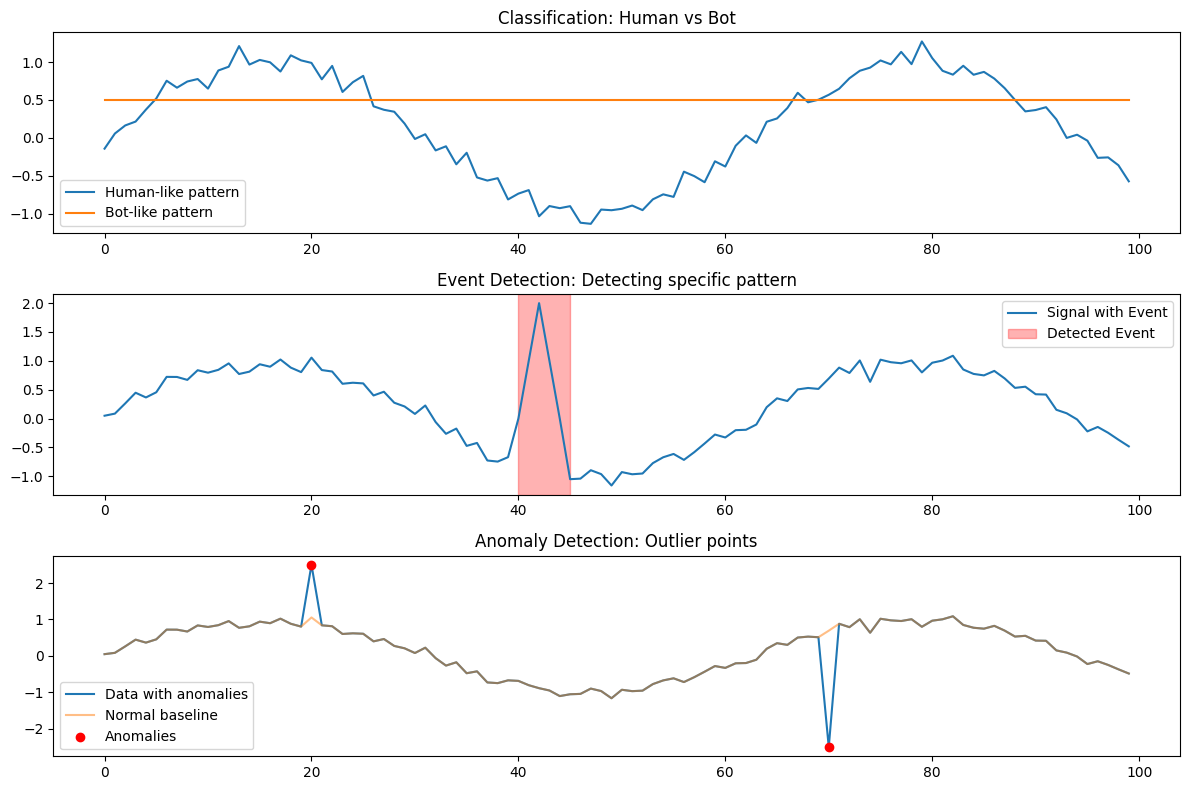

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
time = np.arange(100)

# 공통 정상 시계열 데이터
data = np.sin(time * 0.1) + np.random.normal(scale=0.1, size=len(time))

# 1. Classification: 사람 vs 봇 (간단히 패턴 비교용)
human = np.sin(time * 0.1) + np.random.normal(scale=0.1, size=len(time))
bot = np.ones(len(time)) * 0.5  # 일정한 값

# 2. Event Detection: 특정 패턴 심어두기
event_pattern = np.array([0,1,2,1,0])
signal = data.copy()
signal[40:45] = event_pattern

# 3. Anomaly Detection: 이상치 추가
anomaly_data = data.copy()
anomaly_points = {20: 2.5, 70: -2.5}
for k,v in anomaly_points.items():
    anomaly_data[k] = v

# 그림 그리기
fig, axes = plt.subplots(3,1,figsize=(12,8))

# Classification
axes[0].plot(time, human, label="Human-like pattern")
axes[0].plot(time, bot, label="Bot-like pattern")
axes[0].set_title("Classification: Human vs Bot")
axes[0].legend()

# Event Detection
axes[1].plot(time, signal, label="Signal with Event")
axes[1].axvspan(40,45, color="red", alpha=0.3, label="Detected Event")
axes[1].set_title("Event Detection: Detecting specific pattern")
axes[1].legend()

# Anomaly Detection
axes[2].plot(time, anomaly_data, label="Data with anomalies")
axes[2].plot(time, data, alpha=0.5, label="Normal baseline")
axes[2].scatter(list(anomaly_points.keys()), list(anomaly_points.values()), color="red", label="Anomalies", zorder=5)
axes[2].set_title("Anomaly Detection: Outlier points")
axes[2].legend()

plt.tight_layout()
plt.show()


### ✅ 시계열 활용 분야 Summary

#### 1. 분류 (Classification) → 시계열 전체의 패턴을 보고 그것이 어떤 클래스에 속하는지 판별

> 예시: 웹사이트 방문자의 활동 로그를 보고 사람인지 봇인지 분류

> 특징: 전체 시계열을 하나의 단위로 해석

#### 2. 이벤트 탐지 (Event Detection) → 긴 시계열 속에서 특정 이벤트/패턴이 발생한 순간을 탐지

> 예시: 음성 데이터에서 “OK Google” 같은 핫워드 발생 시점 탐지

> 특징: 부분 구간을 찾아내는 문제

#### 3. 이상치 탐지 (Anomaly Detection) → 정상적인 패턴에서 벗어난 비정상적 데이터 포인트를 찾아냄

> 예시: 센서 데이터에서 기계 고장 신호, 금융 거래 데이터에서 이상 거래 탐지

> 특징: 정상 분포 범위와 비교해 **이탈점(outlier)**을 판별

### <font color='orange'>**Understanding timeseries_dataset_from_array()**

In [ ]:
import numpy as np
import keras

int_sequence = np.arange(10)

print('Orgonal Data')
print(int_sequence)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

print('\n')

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))


Orgonal Data
[0 1 2 3 4 5 6 7 8 9]


[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [ ]:
# 24시간 동안 10분 간격 데이터 생성
data_points_per_hour = 6
total_hours = 24
num_data_points = total_hours * data_points_per_hour + 1 # 145개

# 가상 온도 데이터 (sin 함수를 이용해 주기적인 패턴 생성)
time = np.linspace(0, 2 * np.pi, num_data_points)
temperature = 20 + 5 * np.sin(time) + np.random.randn(num_data_points) * 0.5
temperature = np.arange(1, num_data_points+1)
time_series_data = pd.DataFrame(data={'temperature': temperature},
                                  index=pd.date_range(start='2023-01-01', periods=num_data_points, freq='10T'))

display(time_series_data.head())
print(f"총 데이터 포인트 수: {len(time_series_data)}")

/tmp/ipython-input-428577726.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  index=pd.date_range(start='2023-01-01', periods=num_data_points, freq='10T'))


,temperature
2023-01-01 00:00:00,1
2023-01-01 00:10:00,2
2023-01-01 00:20:00,3
2023-01-01 00:30:00,4
2023-01-01 00:40:00,5


총 데이터 포인트 수: 145


In [ ]:
# 파라미터 설정
sampling_rate = 6
sequence_length = 6
delay = sampling_rate * (sequence_length + 1 - 1)  # 1시간 뒤 예측
print(f'delay: {delay}\n\n')

# 전체 데이터를 numpy 배열로 변환
data = time_series_data['temperature'].values

# 시계열 데이터셋 생성
dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=data[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=32,
)

# 생성된 데이터셋의 첫 번째 배치 확인
for inputs, targets in dataset.take(1):
    print("입력 데이터 (과거 1시간 데이터):")
    print(inputs[0].numpy().flatten())
    print("\n정답 데이터 (1시간 뒤의 온도):")
    print(targets[0].numpy())
    print(f"\n입력 데이터 형태: {inputs.shape}")
    print(inputs)
    print(f"정답 데이터 형태: {targets.shape}")
    print(targets)

delay: 36


입력 데이터 (과거 1시간 데이터):
[ 1  7 13 19 25 31]

정답 데이터 (1시간 뒤의 온도):
37

입력 데이터 형태: (32, 6)
tf.Tensor(
[[ 1  7 13 19 25 31]
 [ 2  8 14 20 26 32]
 [ 3  9 15 21 27 33]
 [ 4 10 16 22 28 34]
 [ 5 11 17 23 29 35]
 [ 6 12 18 24 30 36]
 [ 7 13 19 25 31 37]
 [ 8 14 20 26 32 38]
 [ 9 15 21 27 33 39]
 [10 16 22 28 34 40]
 [11 17 23 29 35 41]
 [12 18 24 30 36 42]
 [13 19 25 31 37 43]
 [14 20 26 32 38 44]
 [15 21 27 33 39 45]
 [16 22 28 34 40 46]
 [17 23 29 35 41 47]
 [18 24 30 36 42 48]
 [19 25 31 37 43 49]
 [20 26 32 38 44 50]
 [21 27 33 39 45 51]
 [22 28 34 40 46 52]
 [23 29 35 41 47 53]
 [24 30 36 42 48 54]
 [25 31 37 43 49 55]
 [26 32 38 44 50 56]
 [27 33 39 45 51 57]
 [28 34 40 46 52 58]
 [29 35 41 47 53 59]
 [30 36 42 48 54 60]
 [31 37 43 49 55 61]
 [32 38 44 50 56 62]], shape=(32, 6), dtype=int64)
정답 데이터 형태: (32,)
tf.Tensor(
[37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68], shape=(32,), dtype=int64)
